# DATAPIPELINE

Our goal is to create a **Aggregation Datapipeline** using the public api's from US Bureau of Labour and Statistics website 

We would be storing our data in pandas dataframe and exporting it in csv format hopefully

the data would be listed in state denominations, the districts data will be aggregated to represent state data,

all the stored api keys would be in .env file




In [67]:
# Importing all the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import prettytable
import csv

## Loading the relevant Series IDs from 'data.bls.gov', 

### We have picked the series in relevance to MNREGA'S KPI's

Like for example **QUARTERLY GROSS JOB GAINS** could the number of person-days generated under MNREGA each quarter could serve as a rough proxy.

other parrallel series like Employment-Population Ratio can be related to percentage of rural households with at least one member working under MNREGA could be a similar metric.

In [68]:
#loading all the relevant KPI
import os
from dotenv import load_dotenv, dotenv_values


load_dotenv()

API_KEY = os.getenv("API_KEY")

Quarterly_gross_job_gains = os.getenv("QUARTERLY_GROSS_JOB_GAINS")
Quarterly_gross_job_loss = os.getenv("QUARTERLY_GROSS_JOB_LOSSES")

Employment_lvl = os.getenv("EMPLOYMENT_LVL")
Employment_population_ratio = os.getenv("EMPLOYMENT_POPULATION_RATIO")

Labour_force_participation = os.getenv("LABOR_FORCE_PARTICIPATION_RATE")
Total_avg_weekly_Hrs = os.getenv("TOTAL_AVG_WEEKLY_HRS")
Avg_weekly_earnings = os.getenv("AVG_WEEKLY_EARNINGS")

Avg_hourly_earnings_all_employees = os.getenv("AVG_HOURLY_EARNINGS_ALL_EMPLOYEES")

## Pick the relevant Hyperparameters 

- Series name 
- Start Year of Series
- End Year of Series

In [128]:
# Picking the relevant Hyperparameters and series ID
collection = []

collection.append(Quarterly_gross_job_gains)
collection.append(Quarterly_gross_job_loss)

start_year = 2011
end_year = 2022

start_year = str(start_year)
end_year = str(end_year)



In [129]:
# Making the request call

headers = {'Content-type': 'application/json'}

data = json.dumps({
    "seriesid": collection,
    "startyear":start_year,
    "endyear": end_year})

p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)

json_data = json.loads(p.text)

## Our Function to analyse the structure of api call

In [130]:
def analyze_schema(data, level=1):
    # Recursively analyze the schema of a JSON object or array.
    if isinstance(data, dict):
        schema = {}
        for key, value in data.items():
            schema[key] = analyze_schema(value, level + 1)
        return schema
    elif isinstance(data, list):
        if data:
            return [analyze_schema(data[0], level + 1)]
        else:
            return ["Empty List"]
    else:
        return type(data).__name__
    

analyze_schema(json_data)

{'status': 'str',
 'responseTime': 'int',
 'message': ['str'],
 'Results': {'series': [{'seriesID': 'str',
    'data': [{'year': 'str',
      'period': 'str',
      'periodName': 'str',
      'value': 'str',
      'footnotes': [{'code': 'str', 'text': 'str'}]}]}]}}

In [131]:
# Helper Functions
def Quater_year(year: list[int]):
    for i in range(1,len(year)):
        if year[i] != year[i-1] and (year[i-1] * 4) % 4 == 3:
            continue
        year[i] = year[i-1] + 0.25
        
    return year

def Month_year(year: list[int]):
    for i in range(1,len(year)):
        if year[i] != year[i-1] and (year[i-1] * 10) % 10 == 0:
            continue
        year[i] = year[i-1] + 0.1
        
    return year
def convert_str_int_list(year: list[str]):
    for i in range(len(year)):
        x = year[i]
        year[i] = int(x)
    return year

### Extracting the Data from API  

### preprocessing it and Storing it in Dataframe 



In [136]:
if json_data['status'] == "REQUEST_SUCCEEDED":
    # Extraction the year and period data
    year = []
    period = []
    series = json_data['Results']['series'][0]
    
    for item in series['data']:
        year.append(item['year'])
        period.append(item['period'])
    year.reverse()
    period.reverse()
    
    if period[0] == "M01":
        spaced_year = Month_year(convert_str_int_list(year))
    else:   
        spaced_year = Quater_year(convert_str_int_list(year))

    
    values = []
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        series_data = []
        for item in series['data']:
            series_data.append(item['value'])
        series_data.reverse()
        values.append(series_data)
        
    # Inserting the value in dictionary
    data = {
        "timestamp": year,
        "period": period
    }
    for i in range(len(collection)):
        data.update({f'{os.getenv(collection[i])}': values[i]})
        
    df = pd.DataFrame(data)
    
    df.set_index("timestamp", inplace=True)

In [133]:
df.head(20)

,period,QUARTERLY_GROSS_JOB_GAINS,QUARTERLY_GROSS_JOB_LOSSES
timestamp,,,
2011.00,Q01,6540,6206
2011.25,Q02,6966,6384
2011.50,Q03,7205,6364
2011.75,Q04,6865,6530
2012.00,Q01,7080,6132
2012.25,Q02,7051,6435
2012.50,Q03,6881,6629
2012.75,Q04,7110,6415
2013.00,Q01,6941,6383


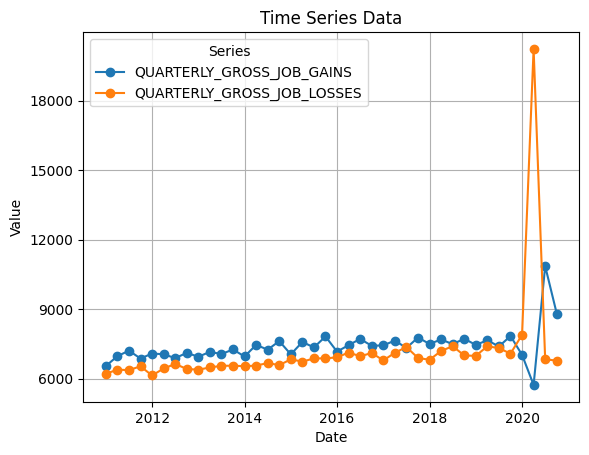

In [134]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

for i in range(len(collection)):
    column = df.columns[1 + i]
    df[column] = pd.to_numeric(df[column], errors="coerce")  # Convert to float
    plt.plot(spaced_year, df[column], marker='o', label=column)

# Get current axis and set smooth y-axis ticks
ax = plt.gca()  # Get current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Controls number of y-axis ticks

# Customize the plot
plt.title("Time Series Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(title="Series")
plt.grid(True)

# Show the plot
plt.show()



In [135]:
#Exporting the dataframe into excel
df.to_csv("out.csv")